# Numpy Network 1

---

### This is the first neural network I will be implementing

- I will be using NumPy to implement this neural network.
- This is the first numpy network I will be implementing without any guidance from a course etc.
- The initial architecture has not been decided but I will once I implement it.
- I am aiming for a NN of 50 - 20 - 10 - 5 - 1

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
current_dir = Path.cwd()
parent_dir = current_dir.parent.parent


### We will start by importing and preparing our data

In [2]:
dev_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"dev_data.pkl")
test_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"test_data.pkl")
training_data = pd.read_pickle(parent_dir/"Resources"/"FinalData"/"training_data.pkl")
training_data.shape

(254696, 446)

In [3]:
training_data_x = training_data.drop(columns = ['Final Output'])
training_data_y = training_data['Final Output']
training_data_x = training_data_x.reset_index(['Over', 'Ball'])

dev_data_x = dev_data.drop(columns = ['Final Output'])
dev_data_y = dev_data['Final Output']
dev_data_x = dev_data_x.reset_index(['Over', 'Ball'])

C:\Users\HOME\anaconda3\lib\site-packages\pandas\core\generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [4]:
dev_data_x.columns.get_level_values(0).unique()

Index(['Over', 'Ball', 'Player Status', 'Inning Data', 'Batting Stats',
       'Bowling Stats', 'Ground Data'],
      dtype='object')

In [5]:
dev_data_x['Inning Data']

Inning Data              
                       score Total Wickets
        Country                           
352674  England          4.0           0.0
        England          4.0           0.0
        England          5.0           0.0
        England          5.0           0.0
        England          9.0           0.0
...                      ...           ...
1361770 Malaysia       151.0           7.0
        Malaysia       152.0           7.0
        Malaysia       156.0           7.0
        Malaysia       157.0           7.0
        Malaysia       163.0           7.0

[23552 rows x 2 columns]

In [6]:
print(training_data_x.shape)
print(training_data_y.shape)
print(dev_data_x.shape)
print(dev_data_y.shape)

(254696, 447)
(254696, 1)
(23552, 447)
(23552, 1)


NumPy Implementation of final_data

In [7]:
train_x = training_data_x.to_numpy().T
train_y = training_data_y.to_numpy().T
dev_x = dev_data_x.to_numpy().T
dev_y = dev_data_y.to_numpy().T
print(train_x.shape)
print(train_y.shape)
print(dev_x.shape)
print(dev_y.shape)

(447, 254696)
(1, 254696)
(447, 23552)
(1, 23552)


Using a Mask to get only the final 10 overs for training

In [8]:
train_overs = 0

train_mask = (training_data_x['Over'] > train_overs).to_numpy()
dev_mask = (dev_data_x['Over'] > train_overs).to_numpy()

train_x = train_x[:, train_mask]
train_y = train_y[:, train_mask]
dev_x = dev_x[:, dev_mask]
dev_y = dev_y[:, dev_mask]

In [9]:
print(train_y.shape)

(1, 240679)


In [10]:
diff = train_x.shape[1] % 256
print(diff)

39


In [11]:
train_x_batched = np.hstack((train_x, train_x[:,0:256 - diff]))
train_y_batched = np.hstack((train_y, train_y[:,0:256 - diff]))
print(train_x_batched.shape)
print(train_y_batched.shape)
print(train_x_batched.shape[1] % 256)

(447, 240896)
(1, 240896)
0


In [12]:
train_y_batched[:, 32:64].shape

(1, 32)

In [13]:
# Randomising data
random_mask = np.random.permutation(train_y_batched.shape[1])
train_x_batched = train_x_batched[:, random_mask]
train_y_batched = train_y_batched[:, random_mask]

### Time to define a few important variables and functions

In [14]:
input_size = train_x_batched.shape[0]
print(input_size)
hidden_layers = 5
output_size = 1
num_batches = train_y_batched.shape[1] // 256
print(num_batches)

447
941


In [15]:
def relu(num):
    return num * (num > 0)

In [16]:
class AdamOptim:
    def __init__(self, eta=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.m_dw, self.v_dw = 0, 0
        self.m_db, self.v_db = 0, 0
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.eta = eta
    def update(self, t, w, b, dw, db):
        ## dw, db are from current minibatch
        ## momentum beta 1
        # *** weights *** #
        self.m_dw = self.beta1*self.m_dw + (1-self.beta1)*dw
        # *** biases *** #
        self.m_db = self.beta1*self.m_db + (1-self.beta1)*db

        ## rms beta 2
        # *** weights *** #
        self.v_dw = self.beta2*self.v_dw + (1-self.beta2)*(dw**2)
        # *** biases *** #
        self.v_db = self.beta2*self.v_db + (1-self.beta2)*(db**2)

        ## bias correction
        m_dw_corr = self.m_dw/(1-self.beta1**t)
        m_db_corr = self.m_db/(1-self.beta1**t)
        v_dw_corr = self.v_dw/(1-self.beta2**t)
        v_db_corr = self.v_db/(1-self.beta2**t)

        ## update weights and biases
        w = w - self.eta*(m_dw_corr/(np.sqrt(v_dw_corr)+self.epsilon))
        b = b - self.eta*(m_db_corr/(np.sqrt(v_db_corr)+self.epsilon))
        return w, b

### Let's define a class for a hidden layer

In [35]:
class layer:
    def __init__(self, input_size, units):
        self.units = units
        self.weights = np.random.randn(units, input_size)*0.0001
        self.bias = np.zeros((units, 1))
        self.optimizer = AdamOptim()
        
    def __call__(self, inp):
        self.x = inp
        self.m = inp.shape[1]
        self.y = np.dot(self.weights, inp) + self.bias
        return self.y
    
    def back_prop(self, dy):
        self.dW = (1/self.m) * np.dot(dy, self.x.T)
        self.db = (1/self.m) * np.sum(dy, axis = 1, keepdims = True)
        self.dx = np.dot(self.weights.T, dy)
        return self.dx
    
    
    
    def grad_des(self, t):
        self.weights, self.bias = self.optimizer.update(t, self.weights, self.bias, self.dW, self.db)

In [36]:
class hidden_layer (layer):
    
    def __init__(self, input_size, units):
        super().__init__(input_size, units)
    
    def __call__(self, inp):
        super().__call__(inp)
        self.z = relu(self.y)
        return self.z
        
    def back_prop(self, dz):
        dy = dz * (self.y > 0)
        self.dy = dy
        super().back_prop(dy)
        return self.dx
        

In [37]:
''' class final_layer:
    def __init__(self, input_size, units):
        self.units = units
        self.weights = np.random.randn(units, input_size)
        self.bias = np.zeros((units, 1))
        self.m = self.inp.shape[1]
        
    def __call__(self, inp):
        self.x = inp
        self.z = np.dot(self.weights, inp) + self.bias
    
    def back_prop(self, dy, learning_rate, beta1, beta2):
        self.dW = (1/self.m) * np.dot(dy, self.x.T)
        self.db = (1/self.m) * np.sum(dy, axis = 1, keepdims = True)
        self.dx = np.dot(W.T, dy)
        return self.dx
'''
print()

In [38]:
class sequence:
    def __init__(self, layer_list):
        self.layers = layer_list
    
    def forward_propagate(self, inp):
        y = inp
        for layer in self.layers:
            y = layer(y)
        return y
    
    def calculate_loss(self, y_pred, y_true):
        mse = np.mean((y_true - y_pred)**2)
        self.loss = mse
        return mse
    
    def back_propagate(self, y_pred, y_true):
        dz = 2*(y_pred - y_true)
        for layer in self.layers[::-1]:
            dz = layer.back_prop(dz)
    
    def grad_descent(self, t):
        for layer in self.layers:
            layer.grad_des(t)
    

### Defining a Demo model now

In [143]:
model_demo = sequence([
    hidden_layer(1, 3),
    layer(3, 1)
])

demo_data_x = np.array([[1, 2, 3, 4, 5]])
demo_data_y = (demo_data_x * 5) + 10
demo_data_x.shape

y_pred = model_demo.forward_propagate(demo_data_x)

model_demo.calculate_loss(y_pred, demo_data_y)

losses = []
for x in range(1, 100000):
    y_pred = model_demo.forward_propagate(demo_data_x)
    loss = model_demo.calculate_loss(y_pred, demo_data_y)
    losses.append(loss)
    model_demo.back_propagate(y_pred, demo_data_y)
    model_demo.grad_descent(x)

y_pred

array([[15., 20., 25., 30., 35.]])

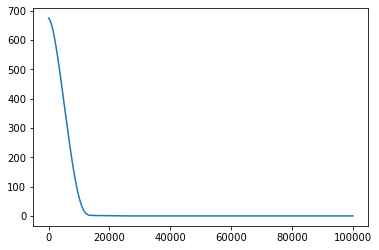

In [144]:
plt.plot(losses[30:])
plt.show()

## Training the actual model

In [50]:
num_of_epochs = 200
num_batches = train_y_batched.shape[1] // 256
print(num_batches)

941


In [51]:
final_model = sequence([
    hidden_layer(input_size, 100),
    hidden_layer(100, 50),
    hidden_layer(50, 50),
    hidden_layer(50, 30),
    hidden_layer(30, 20),
    hidden_layer(20, 10),
    hidden_layer(10, 7),
    hidden_layer(7, 5),
    layer(5, 1)
])

In [52]:
losses_train = []
losses_dev = []
loss_train = 0
for epoch in range(num_of_epochs):
    for batch in range(num_batches):
        t = epoch * num_batches + batch + 1 # Step Number
        
         
        if batch % 200 == 0:
            y_dev_pred = final_model.forward_propagate(dev_x)
            loss_dev = final_model.calculate_loss(y_dev_pred, dev_y)
            losses_dev.append(loss_dev)
            
            print(f"Epoch {epoch} ------------- Batch {batch}:")
            print(f"Training Set Loss: {loss_train} -------- Dev Set Loss: {loss_dev}")
            
        # Finding Y pred
        y_pred = final_model.forward_propagate(train_x_batched[:, 0 + 256 * batch: 256 + 256 * batch])
        
        # Finding and Storing Loss
        loss_train = final_model.calculate_loss(y_pred, train_y_batched[:, 0 + 256 * batch: 256 + 256 * batch])
        losses_train.append(loss_train)
       
        
        
        # Back Propagation and Gradient Descent
        final_model.back_propagate(y_pred, train_y_batched[:, 0 + 256 * batch: 256 + 256 * batch])
        final_model.grad_descent(t)

Epoch 0 ------------- Batch 0:
Training Set Loss: 0 -------- Dev Set Loss: 23672.81241508152
Epoch 0 ------------- Batch 200:
Training Set Loss: 24209.61728449424 -------- Dev Set Loss: 23664.683309529304
Epoch 0 ------------- Batch 400:
Training Set Loss: 3069.341127461382 -------- Dev Set Loss: 3222.4534532088223
Epoch 0 ------------- Batch 600:
Training Set Loss: 2931.211090813277 -------- Dev Set Loss: 2892.3677414931217
Epoch 0 ------------- Batch 800:
Training Set Loss: 2478.0313442329243 -------- Dev Set Loss: 2550.3640089133737
Epoch 1 ------------- Batch 0:
Training Set Loss: 2508.9540335872143 -------- Dev Set Loss: 2290.0162510590976
Epoch 1 ------------- Batch 200:
Training Set Loss: 1986.4130457909814 -------- Dev Set Loss: 1888.672462877989
Epoch 1 ------------- Batch 400:
Training Set Loss: 1585.9373999420484 -------- Dev Set Loss: 1514.414015477372
Epoch 1 ------------- Batch 600:
Training Set Loss: 1440.823819478143 -------- Dev Set Loss: 1251.2705544529763
Epoch 1 ---

Epoch 14 ------------- Batch 800:
Training Set Loss: 659.3713689621648 -------- Dev Set Loss: 614.3790713612201
Epoch 15 ------------- Batch 0:
Training Set Loss: 565.1889364873699 -------- Dev Set Loss: 613.7511943452788
Epoch 15 ------------- Batch 200:
Training Set Loss: 692.6132879679105 -------- Dev Set Loss: 616.0160465689517
Epoch 15 ------------- Batch 400:
Training Set Loss: 613.8081574305788 -------- Dev Set Loss: 615.3138303639093
Epoch 15 ------------- Batch 600:
Training Set Loss: 669.4954506842238 -------- Dev Set Loss: 612.860563652592
Epoch 15 ------------- Batch 800:
Training Set Loss: 654.6621280247583 -------- Dev Set Loss: 614.0536594974052
Epoch 16 ------------- Batch 0:
Training Set Loss: 553.0388517230848 -------- Dev Set Loss: 612.0317980001286
Epoch 16 ------------- Batch 200:
Training Set Loss: 686.5929357393593 -------- Dev Set Loss: 615.4085494167346
Epoch 16 ------------- Batch 400:
Training Set Loss: 604.6213158865685 -------- Dev Set Loss: 615.15594342506

Epoch 29 ------------- Batch 600:
Training Set Loss: 596.0297179514882 -------- Dev Set Loss: 594.6485802033162
Epoch 29 ------------- Batch 800:
Training Set Loss: 614.6463712438679 -------- Dev Set Loss: 600.559335451608
Epoch 30 ------------- Batch 0:
Training Set Loss: 489.36399836918145 -------- Dev Set Loss: 593.0239096360864
Epoch 30 ------------- Batch 200:
Training Set Loss: 630.1522614134117 -------- Dev Set Loss: 597.1360827164887
Epoch 30 ------------- Batch 400:
Training Set Loss: 554.3153373036466 -------- Dev Set Loss: 600.2523172306048
Epoch 30 ------------- Batch 600:
Training Set Loss: 588.3738339366057 -------- Dev Set Loss: 593.9791344234117
Epoch 30 ------------- Batch 800:
Training Set Loss: 611.5032217558114 -------- Dev Set Loss: 600.2784676980203
Epoch 31 ------------- Batch 0:
Training Set Loss: 485.9197143395992 -------- Dev Set Loss: 592.2387947841902
Epoch 31 ------------- Batch 200:
Training Set Loss: 626.4202653867513 -------- Dev Set Loss: 596.5996864517

Epoch 44 ------------- Batch 400:
Training Set Loss: 515.4152374434318 -------- Dev Set Loss: 607.3706320131062
Epoch 44 ------------- Batch 600:
Training Set Loss: 519.338946661002 -------- Dev Set Loss: 597.7897142018317
Epoch 44 ------------- Batch 800:
Training Set Loss: 569.8237013476454 -------- Dev Set Loss: 610.2773335841861
Epoch 45 ------------- Batch 0:
Training Set Loss: 444.49942856043526 -------- Dev Set Loss: 599.2478077063222
Epoch 45 ------------- Batch 200:
Training Set Loss: 591.8070580714433 -------- Dev Set Loss: 603.9788728002268
Epoch 45 ------------- Batch 400:
Training Set Loss: 512.0590959926931 -------- Dev Set Loss: 608.9468468726457
Epoch 45 ------------- Batch 600:
Training Set Loss: 516.0598614614144 -------- Dev Set Loss: 598.8637350548222
Epoch 45 ------------- Batch 800:
Training Set Loss: 564.9541921830794 -------- Dev Set Loss: 611.8127602096253
Epoch 46 ------------- Batch 0:
Training Set Loss: 441.4530758667587 -------- Dev Set Loss: 600.3999100613

Epoch 59 ------------- Batch 200:
Training Set Loss: 488.4851889168496 -------- Dev Set Loss: 617.8392655608296
Epoch 59 ------------- Batch 400:
Training Set Loss: 434.170336925077 -------- Dev Set Loss: 629.8878591193525
Epoch 59 ------------- Batch 600:
Training Set Loss: 433.3551685002159 -------- Dev Set Loss: 616.057173928577
Epoch 59 ------------- Batch 800:
Training Set Loss: 444.75753284000336 -------- Dev Set Loss: 627.7691734330102
Epoch 60 ------------- Batch 0:
Training Set Loss: 371.4710213217397 -------- Dev Set Loss: 615.6363875834769
Epoch 60 ------------- Batch 200:
Training Set Loss: 478.61386575621003 -------- Dev Set Loss: 619.9795777322057
Epoch 60 ------------- Batch 400:
Training Set Loss: 422.2092054566154 -------- Dev Set Loss: 631.8010954194601
Epoch 60 ------------- Batch 600:
Training Set Loss: 425.8518053083392 -------- Dev Set Loss: 617.3569118840767
Epoch 60 ------------- Batch 800:
Training Set Loss: 437.10540496797546 -------- Dev Set Loss: 628.2679638

Epoch 74 ------------- Batch 0:
Training Set Loss: 278.2662928263777 -------- Dev Set Loss: 752.9639272464755
Epoch 74 ------------- Batch 200:
Training Set Loss: 306.36365997943454 -------- Dev Set Loss: 751.0892050949624
Epoch 74 ------------- Batch 400:
Training Set Loss: 256.6417405366065 -------- Dev Set Loss: 758.560715742309
Epoch 74 ------------- Batch 600:
Training Set Loss: 261.93538559643014 -------- Dev Set Loss: 755.6443856451871
Epoch 74 ------------- Batch 800:
Training Set Loss: 291.7495384831249 -------- Dev Set Loss: 766.4675429050226
Epoch 75 ------------- Batch 0:
Training Set Loss: 266.3100656359602 -------- Dev Set Loss: 792.6466750924963
Epoch 75 ------------- Batch 200:
Training Set Loss: 282.35310889558946 -------- Dev Set Loss: 777.5673935745551
Epoch 75 ------------- Batch 400:
Training Set Loss: 237.99336539632833 -------- Dev Set Loss: 782.7153801955222
Epoch 75 ------------- Batch 600:
Training Set Loss: 230.6134453526506 -------- Dev Set Loss: 796.2215521

Epoch 88 ------------- Batch 600:
Training Set Loss: 105.46025805774536 -------- Dev Set Loss: 1267.226709591231
Epoch 88 ------------- Batch 800:
Training Set Loss: 121.19060466415468 -------- Dev Set Loss: 1252.5578778164208
Epoch 89 ------------- Batch 0:
Training Set Loss: 116.48455825031664 -------- Dev Set Loss: 1282.1753546242219
Epoch 89 ------------- Batch 200:
Training Set Loss: 132.374713218559 -------- Dev Set Loss: 1270.7429327614147
Epoch 89 ------------- Batch 400:
Training Set Loss: 109.78767477046527 -------- Dev Set Loss: 1261.2797495557857
Epoch 89 ------------- Batch 600:
Training Set Loss: 103.84336863986469 -------- Dev Set Loss: 1294.4329367664827
Epoch 89 ------------- Batch 800:
Training Set Loss: 114.9351060904679 -------- Dev Set Loss: 1286.3065480485377
Epoch 90 ------------- Batch 0:
Training Set Loss: 110.76060373126796 -------- Dev Set Loss: 1307.3821672671952
Epoch 90 ------------- Batch 200:
Training Set Loss: 125.57775043410517 -------- Dev Set Loss: 1

Epoch 103 ------------- Batch 200:
Training Set Loss: 58.59474200826256 -------- Dev Set Loss: 1582.3263174457759
Epoch 103 ------------- Batch 400:
Training Set Loss: 62.83995751931464 -------- Dev Set Loss: 1668.7405341840479
Epoch 103 ------------- Batch 600:
Training Set Loss: 50.53595498966876 -------- Dev Set Loss: 1599.4395776160582
Epoch 103 ------------- Batch 800:
Training Set Loss: 56.065256749855365 -------- Dev Set Loss: 1615.3218994572817
Epoch 104 ------------- Batch 0:
Training Set Loss: 67.71518011745407 -------- Dev Set Loss: 1621.5594808131575
Epoch 104 ------------- Batch 200:
Training Set Loss: 57.531572331662126 -------- Dev Set Loss: 1607.311840809328
Epoch 104 ------------- Batch 400:
Training Set Loss: 56.650317022259614 -------- Dev Set Loss: 1689.789343100876
Epoch 104 ------------- Batch 600:
Training Set Loss: 50.56558289857131 -------- Dev Set Loss: 1617.7815962074194
Epoch 104 ------------- Batch 800:
Training Set Loss: 51.945883262674286 -------- Dev Set

Epoch 117 ------------- Batch 800:
Training Set Loss: 29.21181759013785 -------- Dev Set Loss: 1829.7668754327765
Epoch 118 ------------- Batch 0:
Training Set Loss: 29.44393935488476 -------- Dev Set Loss: 1819.3629339933652
Epoch 118 ------------- Batch 200:
Training Set Loss: 28.887140988927637 -------- Dev Set Loss: 1858.625513158493
Epoch 118 ------------- Batch 400:
Training Set Loss: 37.30673806426399 -------- Dev Set Loss: 1853.3274733649437
Epoch 118 ------------- Batch 600:
Training Set Loss: 26.006220432268194 -------- Dev Set Loss: 1855.348166020643
Epoch 118 ------------- Batch 800:
Training Set Loss: 27.823303778140872 -------- Dev Set Loss: 1839.3389037042757
Epoch 119 ------------- Batch 0:
Training Set Loss: 28.798016226899506 -------- Dev Set Loss: 1833.1058374286822
Epoch 119 ------------- Batch 200:
Training Set Loss: 26.937830757213334 -------- Dev Set Loss: 1877.0541153618083
Epoch 119 ------------- Batch 400:
Training Set Loss: 34.002227670599765 -------- Dev Set

KeyboardInterrupt: 

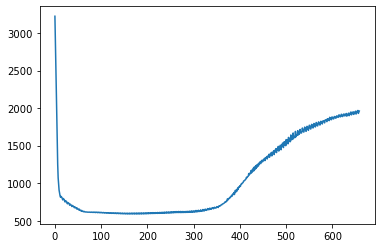

In [53]:

plt.plot(losses_dev[2:])
plt.show()

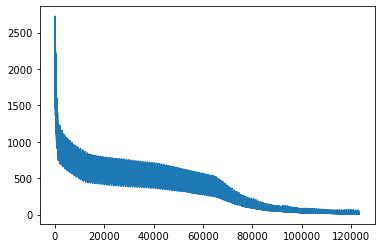

In [54]:
plt.plot(losses_train[1000:])
plt.show()

# Now to measure the accuracy of the model

In [28]:
def get_accuracy(y_true, y_pred):
    result =  (y_true - 20 < y_pred) * (y_pred < y_true + 20)
    return (np.sum(result)/result.size) * 100

get_accuracy(np.array([32, 45, 62, 12]).T, np.array([33, 13414, 10, 30]).T)

50.0

In [59]:
thres_overs = 10

mask = (dev_data_x['Over'] > thres_overs).to_numpy()
dev_x = dev_data_x.to_numpy().T
dev_y = dev_data_y.to_numpy().T

prediction_x = dev_x[:, mask]
prediction_y = dev_y[:, mask]
print(prediction_x.shape)
print(prediction_y.shape)

(447, 9823)
(1, 9823)


In [60]:
y_pred = final_model.forward_propagate(prediction_x)
loss_pred = final_model.calculate_loss(y_pred, prediction_y)
accuracy = get_accuracy(prediction_y, y_pred)
print(loss_pred)
print(accuracy)

1862.735022776114
37.045709050188336


In [61]:
y_pred

array([[170.92242721, 169.18901964, 170.68081393, ..., 148.8274515 ,
        148.91428421, 148.50415154]])